# Sentence Tokenization

<b>Note:</b>
- If the Acts and Joints were mixed for the chosen year, the OCRed output will contain `{year}_Both.txt` and `{year}_Both_data.tsv`
- If the Acts and Joints were seperate for the chosen year, the OCRed output will contain `{year}_Acts.txt` and `{year}_Acts_data.tsv`

In [1]:
from nltk.tokenize import PunktSentenceTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import re

pd.set_option('display.max_colwidth', None)

In [2]:
year = 1892

In [3]:
direc = "../OCRed/" + str(year)

# Try reading in "{year}_text.txt" if the Acts and Joints were seperate for the year
try:
    acts_path = direc + "/" + str(year) + "_Acts.txt"
    with open(acts_path, 'r') as f:
        data = f.read()

    # If the read is successful, set a flag that identifies that the Acts and Joints are seperate
    actsSep = True

# However, if the directory contains {year}_Both.txt instead, a FileNotFoundError will be returned for the above code.
# So, catch that error and read in "{year}_Both.txt"
except FileNotFoundError:
    acts_path = direc + "/" + str(year) + "_Both.txt"
    with open(acts_path, 'r') as f:
        data = f.read()
    
    actsSep = False  # The flag being False means that the Acts and Joints are not seperate

# This variable holds all the OCRed text as a String
# data

In [4]:
print("The number of pages OCRed for {year} is: {count}".format(year = year, count = (data.count("\n\n")+1)))

The number of pages OCRed for 1892 is: 384


## Training the tokenizer
Based on this [article](https://subscription.packtpub.com/book/application-development/9781782167853/1/ch01lvl1sec12/training-a-sentence-tokenizer),
- NLTK's default sentence tokenizer is general purpose and usually works quite well. But sometimes it might not be the best choice for our text if it uses nonstandard punctuation or is formatted in a unique way. In such cases, training your own sentence tokenizer can result in much more accurate sentence tokenization.
- The `PunktSentenceTokenizer` class uses an unsupervised learning algorithm to learn what constitutes a sentence break.
    - The specific technique used in this case is called sentence boundary detection. It works by counting punctuation and tokens that commonly end a sentence, such as a period or a newline, then using the resulting frequencies to decide the sentence boundaries.

In [5]:
sent_tokenizer = PunktSentenceTokenizer(data)
sentences = sent_tokenizer.tokenize(data)

# A List of tokens/sentences as seperated by nltk's PunktSentenceTokenizer
# sentences

## Creating the dataframe
Make a new dataframe with the sentences and character lengths as attributes

In [6]:
# Add to a new DataFrame
df = pd.DataFrame()
df["sentence"] = sentences

In [7]:
df["length"] = [len(sentence) for sentence in sentences]
print("Length of the initial dataframe:", df.shape[0], "\nThis is the number of tokenized sentences.")

Length of the initial dataframe: 3010 
This is the number of tokenized sentences.


## Adding page file names
- Add an identifier that specifies which page number that sentence starts on.
- Reading only Acts. <b> Not reading Joints </b>
- The reason to read the files from the directory is to ensure that missing file pages are not missed in the dataframe.

In [8]:
imgs_path = direc + "/images"

imgs = os.listdir(imgs_path)
imgs = [img for img in imgs if "jpg" in img or "tiff" in img or "JPG" in img or "TIFF" in img]
imgs.sort()
print("The number of image files for this year is:", len(imgs))

The number of image files for this year is: 478


In [9]:
fileType = imgs[0].split(".")
fileType = fileType[1]
print(f"The files are of type: .{fileType}")

The files are of type: .jpg


In [10]:
def addPrefix(fileName: str, nameLen: int, fileType: bool) -> str:
    '''
    Since the fileNames from the excel parsing could be any of any length
    (ranging from 1-3), this function appends a string of 0's to the 
    start of the input so that it is 5 lengths long.
    
    Parameters
    ----------
    fileName : str
        The file name that needs to be prefixed
    nameLen : int
        The length of the expected name of the file
        Ex. '00034.jpg' would have length of 5
    fileType: bool
        True if the fileName contains a fileType prefix such as '.tiff'

    Returns
    -------
    str
        A length 5 file name (prefixed with 0's)
    '''
    
    # Remove the file type
    if fileType:
        name = fileName.split(".")[0]
    else:
        name = fileName

    prefix_length = nameLen - len(name)
    prefix = "0" * prefix_length
    
    final_string = prefix + fileName
    return final_string

The imgs list, right now, contains both Acts and Joints.
<br>So, partition the imgs list so that it contains only Acts.

In [11]:
# Get the chracter length of the image file
nameLen = len(imgs[0].split(".")[0])

# Read in CopyofImageCorpusMetadata.xlsx to a pandas frame
# The file needs to be in THE SAME direcotry as this file.
corpusMetaPath = "./Copy of ImageCorpusMetadata.xlsx"
corpusMeta = pd.read_excel(corpusMetaPath)

corpusMeta = corpusMeta[corpusMeta["year"] == year]  # Only the row for this year

# Read the value in the "Acts Start Page File Name" column for the year.
ActsFirstPage = str(int(corpusMeta["Acts Start Page File Name"])) + "." + fileType
ActsFirstPage = addPrefix(ActsFirstPage, nameLen, fileType=True)
print("The first page file name for the acts is", ActsFirstPage)

# Read the value in the "Acts Last Page File Name" column for the year.
ActsLastPage = str(int(corpusMeta["Acts Last Page File Name"])) + "." + fileType
ActsLastPage = addPrefix(ActsLastPage, nameLen, fileType=True)
print("The last page file name for the acts is", ActsLastPage)

# Split the imgs list on the values
ActsFirstPage_indx = imgs.index(ActsFirstPage)
ActsLastPage_indx = imgs.index(ActsLastPage)
imgs = imgs[ActsFirstPage_indx:ActsLastPage_indx+1]

The first page file name for the acts is 045.jpg
The last page file name for the acts is 427.jpg


<br>

<b>Note:</b>
- The OCR text seperates new pages by adding "\n\n".
- However, most likely, the total number of pages does not equal the total count of "\n\n" in the text as the OCR does not add "\n\n" after every page.
- This can be demonstrated by the code cell below:

In [12]:
print(f"Total number of pages: {ActsLastPage_indx+1 - ActsFirstPage_indx}")

# Find the total count for "\n\n"
count = 0
for i in range(0, df.shape[0]):

    if "\n\n" in df.iloc[i]['sentence']:
        count += 1

print(f"The total count for '\\n\\n' is {count}")

Total number of pages: 383
The total count for '\n\n' is 346


<br>
This can be further demonstrated by adding a page identifier in the dataframe which corresponds to the start page of the sentence.

In [13]:
# Have a list of images, which are basically new page identifiers
# A list of tokenized sentences
# Some tokenized sentences will correspond to the same image

# Create a list for the page numbers
# A new page starts when "\n\n" appears in the sentences

df['page'] = np.nan

# Track the index for the imgs list. 
imgs_trk = 0

for i in range(0, df.shape[0]):

    if "\n\n" in df.iloc[i]['sentence'] and i != 0:
        df.at[i, 'page'] = imgs[imgs_trk]

        # if this is the first iteration, then don't increment
        # the list tracker as the first sentence always "\n\n"
        if i != 0:
            imgs_trk += 1

    else:
        df.at[i, 'page'] = imgs[imgs_trk]

By checking the end with of the table with `df.tail()`, we see that the last page values do not correspond with the last page file name for the acts.

In [14]:
df.tail()

,sentence,length,page
3005,The municipal authorities of said town of Beaufort are hereby authorized and empowered to levy a tax upon all real and personal property in said town to an amount not exceeding one (1) per cent.,194,390.jpg
3006,of the assessed value of said property.,39,390.jpg
3007,Szc.,4,390.jpg
3008,3. All Acts or parts of Acts in conflict with or repugnant to this Act are hereby repealed.,91,390.jpg
3009,"Approved January 11th, A. D. 1893.",34,390.jpg


<br>

One way to eliminate this issue is by utilizing the `{year}_Both_data.tsv` (if acts and joints mixed) or `{year}_Acts_data.tsv` (if acts and joints seperated) file from the OCR output.
<br>This file contains each word (in the 2nd last column) and the filename for that word (last column).

In [15]:
if actsSep:
    df_words = pd.read_table(f"{direc}/{year}_Acts_data.tsv")
else:
    df_words = pd.read_table(f"{direc}/{year}_Both_data.tsv")

df_words

,left,top,width,height,conf,text,name
0,0,0,1620,1024,-1.000000,NaN,045.jpg
1,231,224,1153,32,-1.000000,NaN,045.jpg
2,231,224,1153,32,-1.000000,NaN,045.jpg
3,231,224,1153,32,-1.000000,NaN,045.jpg
4,231,226,64,30,96.684166,AN,045.jpg
...,...,...,...,...,...,...,...
199243,445,2197,145,40,96.368355,January,427.jpg
199244,604,2195,90,38,89.207558,"11th,",427.jpg
199245,711,2195,40,31,92.814949,A.,427.jpg
199246,771,2196,41,31,90.454147,D.,427.jpg


<br>
So, to label the page numbers in the dataframe, we can go through the original dataframe and find the start and end words in each sentence.
<br>We, can then find the page numbers for those words, from `df_words` and add them to the original dataframe, `df`.

<br>To start, we need to clean the two dataframes.

In [16]:
# Drop the columns which are unessecary for our analysis
df_words.drop(columns=["left", "top", "width", "height", "conf"], inplace=True)

# Drop the rows which don't contain a word in the "text" column
df_words.dropna(inplace=True)

# Relabel the "name" column to "page" column
df_words.rename(columns={"name": "page"}, inplace=True)

# Reassign index after dropping nas
df_words = df_words.assign(row_number=range(len(df_words)))
df_words.set_index('row_number', inplace=True)

# Drop the 'page' column from the org dataframe
df.drop(columns=['page'], inplace=True)

# Add an empty 'start_page' and 'end_page' column
df['start_page'] = np.nan
df['end_page'] = np.nan

Since, a word can only exist on a single page, we can have unique identifiers for the start and end page for each sentence 

In [17]:
# Tracker for df_words:
words_trkr = 0

# Loop over the original dataframe
for i in range(0, df.shape[0]):
    
    # Remove "\n\n" from the original dataframe as they will interfere with the analysis
    df.at[i, 'sentence'] = df.iloc[i]['sentence'].replace("\n\n", "")

    # For each sentence, extract the first and last word
    tmp_sentence = df.iloc[i]['sentence'].split(" ")
    start, last = tmp_sentence[0], tmp_sentence[-1]

    # Get the page number for the start and end word
    start_page = df_words.iloc[words_trkr]['page']

    try:
        end_page = df_words.iloc[words_trkr + len(tmp_sentence)]['page']
    except:
        end_page = df_words.iloc[words_trkr]['page']
        

    # Remove the filename from the pages:
    start_page = start_page.split(".")[0]
    end_page = end_page.split(".")[0]

    
    # Assign the page number to their respective columns in the dataframe
    df.at[i, 'start_page'] = start_page
    df.at[i, 'end_page'] = end_page
    
    # Update tracker
    words_trkr += len(tmp_sentence)

In [18]:
df.tail(10)

,sentence,length,start_page,end_page
3000,"SecTIoN 1. Be it enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the Board of Phosphate Commissioners of the State be, and they are hereby, authorized and empowered to fix the royalty to be paid the State by parties mining in the navigable waters and the marshes of this State at such amounts, not to exceed two dollars per ton, and for such periods, as they, upon full investigation and examination, may deem advisable: Provided, That six months’ notice be given of any raising of such royalty above the sum of one dollar.",640,427,427
3001,"Approved January 7th, A. D. 1893. AN ACT To RENEW AND AMEND THE CHARTER OF THE TOWN OF BEAUFORT.",96,427,427
3002,"Section 1. Be it enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the charter of the town of Beaufort, with the amendments thereto, are hereby renewed and extended for the term of twenty years.",309,427,427
3003,Sec.,4,427,427
3004,2.,2,427,427
3005,The municipal authorities of said town of Beaufort are hereby authorized and empowered to levy a tax upon all real and personal property in said town to an amount not exceeding one (1) per cent.,194,427,427
3006,of the assessed value of said property.,39,427,427
3007,Szc.,4,427,427
3008,3. All Acts or parts of Acts in conflict with or repugnant to this Act are hereby repealed.,91,427,427
3009,"Approved January 11th, A. D. 1893.",34,427,427


<br>

## Cleaning on Char. lenght
Get rid of sentences with a low number of characters as they might not form meaningful sentences

However, first, get the statistics on the length column to avoid removing meaningful sentence

In [19]:
# Get the statistics for the length column
df["length"].describe()

count    3010.000000
mean      286.785382
std       368.127799
min         1.000000
25%         4.000000
50%       174.000000
75%       406.000000
max      3445.000000
Name: length, dtype: float64

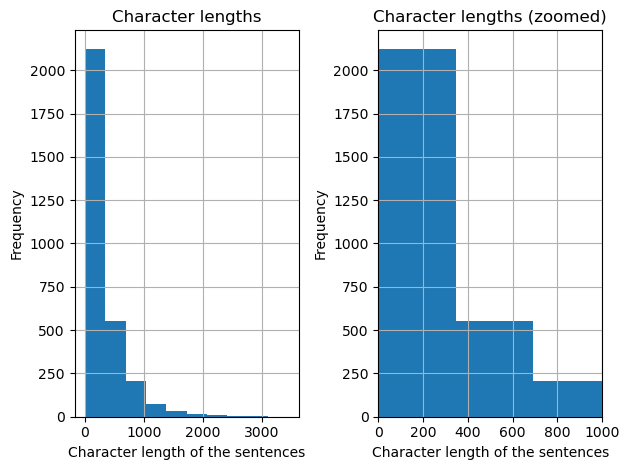

In [20]:
# Plot a histogram for that column
fig, axes = plt.subplots(1, 2)
df.hist(column="length", ax=axes[0])
axes[0].set_title('Character lengths')
axes[0].set(xlabel="Character length of the sentences", ylabel="Frequency")

df.hist(column="length", ax=axes[1])

axes[1].set_title('Character lengths (zoomed)')
axes[1].set(xlabel="Character length of the sentences", ylabel="Frequency", xlim = [0, 1000])
fig.tight_layout()

Create a smaller dataframe, and export it to csv, that only contains the short length sentences.
Check the csv and change the length condition accordingly.

In [21]:
testing_df = df[df['length'] < 50]
testing_df.to_csv(f"{year}_len_testing.csv", index=False)

<br>
Once, the length is decided, create a new dataframe with sentences greater that the length

In [22]:
df_reduced = df[ df["length"] > 50]
print("Length of the cleaned dataframe: ", df_reduced.shape[0])
print("Reduction of about {:.2f}%".format( (1 - df_reduced.shape[0]/df.shape[0]) * 100))

Length of the cleaned dataframe:  2053
Reduction of about 31.79%


In [23]:
df_reduced.reset_index(drop=True, inplace=True)
df_reduced.index.name = "index"

<br>

## Regex Matching
Remove unecessary words, which do not contribute to the overall meaning, in the sentences.

In [24]:
# New dataframe so that the results of the matching can be compared
df_cleaned = df_reduced.copy()

<br>
The following code three separate regex patterns to identify sections, such as "Section 1.", "Sec. 4.", etc. 

Because most sections, which need to be removed, appear either at the start or the start of the ORCed sentence, the pattern finds matches either at the start or the end of the sentence.

In [25]:
# Match either at the start of the sentence or at the end
match_section = re.compile('^(S|s)[a-zA-Z]{2,6}(\.|,|:|;| ){0,2}(\d.){1}|(S|s)[a-zA-Z]{2,6}(\.|,|:|;| ){0,2}(\d.){1}$')

# # Create a new column that will contain the removed words that match the section patter
# df_cleaned['removed'] = np.nan

# Rename 'sentence' column to 'org_sent' to avoid confusion
# df_cleaned.rename(columns={'sentence': 'org_sent'}, inplace=True)

In [26]:
for i in range(0, df_cleaned.shape[0]):
    # df_cleaned.at[i, 'removed'] = "; ".join([x.group() for x in re.finditer(match_section, df_cleaned.iloc[i]['sentence'])])  # Add the matched patterns to the "removed" section
    df_cleaned.at[i, 'sentence'] = re.sub(match_section, '', df_cleaned.iloc[i]['sentence'])  # Remove the matched patterns from sentences

In [27]:
df_cleaned

,sentence,length,start_page,end_page
index,,,,
0,AN ACT to CoNSsTITUTE A BATTALION TO BE KNOWN AS THE NAVAL BATTALION OF VOLUNTEER TROOPS OF SOUTH CAROLINA.,109,045,045
1,"Be tt enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That there shall be allowed, in addition to the companies of the Vol-t unteer Troops of the State of South Carolina as now provided by law, not more than four companies of Naval Militia, which shall constitute a battalion, to be known as the Naval Battalion of the Volunteer Troops of South Carolina.",477,045,046
2,"The officers of this battalion shall consist of a Lieu- tenant Commander, who shall be appointed by the Governor, and whose rank and pay shall assimilate to that of a Major of infantry, and a staff, to consist of one Adjutant, one Ordnance Officer, one Paymaster, who shall be the mustering officer, and one Surgeon, each with the rank of First Lieutenant.",356,046,046
3,They shall be paid the same as battalion staffs in the Volunteer Troops.,72,046,046
4,"There shall also be attached to the staff the following petty officers: One Master-at-Arms, two Yeomen, one Hospital Steward, one Chief Bugler, who shall receive the same pay as the non-commissioned staff of a battalion of infantry.",232,046,046
...,...,...,...,...
2048,"Be it enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the Board of Phosphate Commissioners of the State be, and they are hereby, authorized and empowered to fix the royalty to be paid the State by parties mining in the navigable waters and the marshes of this State at such amounts, not to exceed two dollars per ton, and for such periods, as they, upon full investigation and examination, may deem advisable: Provided, That six months’ notice be given of any raising of such royalty above the sum of one dollar.",640,427,427
2049,"Approved January 7th, A. D. 1893. AN ACT To RENEW AND AMEND THE CHARTER OF THE TOWN OF BEAUFORT.",96,427,427
2050,"Be it enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the charter of the town of Beaufort, with the amendments thereto, are hereby renewed and extended for the term of twenty years.",309,427,427


<br>

## Adding unique id
Since sentences from different volumes will be mixed in the future steps, it is important to label each sentence uniquely.  
Some unique identifiers are:
- year
- order number

In [28]:
df_cleaned.reset_index(inplace=True)
df_cleaned.rename(columns={"index" : "id"}, inplace=True)
# df_cleaned.set_index('id', inplace=True)

In [29]:
# The length of the id of the last row in the dataframe, which is used to assess how many 0's will be prefixed to the other ids
maxNumLength = len(str(df_cleaned.last_valid_index()))

for i in range(0, df_cleaned.shape[0]):
    df_cleaned.at[i, 'id'] = str(year) + "_" + addPrefix(str(df_cleaned.iloc[i]['id']), maxNumLength, fileType=False)

In [30]:
df_cleaned

,id,sentence,length,start_page,end_page
0,1892_0000,AN ACT to CoNSsTITUTE A BATTALION TO BE KNOWN AS THE NAVAL BATTALION OF VOLUNTEER TROOPS OF SOUTH CAROLINA.,109,045,045
1,1892_0001,"Be tt enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That there shall be allowed, in addition to the companies of the Vol-t unteer Troops of the State of South Carolina as now provided by law, not more than four companies of Naval Militia, which shall constitute a battalion, to be known as the Naval Battalion of the Volunteer Troops of South Carolina.",477,045,046
2,1892_0002,"The officers of this battalion shall consist of a Lieu- tenant Commander, who shall be appointed by the Governor, and whose rank and pay shall assimilate to that of a Major of infantry, and a staff, to consist of one Adjutant, one Ordnance Officer, one Paymaster, who shall be the mustering officer, and one Surgeon, each with the rank of First Lieutenant.",356,046,046
3,1892_0003,They shall be paid the same as battalion staffs in the Volunteer Troops.,72,046,046
4,1892_0004,"There shall also be attached to the staff the following petty officers: One Master-at-Arms, two Yeomen, one Hospital Steward, one Chief Bugler, who shall receive the same pay as the non-commissioned staff of a battalion of infantry.",232,046,046
...,...,...,...,...,...
2048,1892_2048,"Be it enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the Board of Phosphate Commissioners of the State be, and they are hereby, authorized and empowered to fix the royalty to be paid the State by parties mining in the navigable waters and the marshes of this State at such amounts, not to exceed two dollars per ton, and for such periods, as they, upon full investigation and examination, may deem advisable: Provided, That six months’ notice be given of any raising of such royalty above the sum of one dollar.",640,427,427
2049,1892_2049,"Approved January 7th, A. D. 1893. AN ACT To RENEW AND AMEND THE CHARTER OF THE TOWN OF BEAUFORT.",96,427,427
2050,1892_2050,"Be it enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the charter of the town of Beaufort, with the amendments thereto, are hereby renewed and extended for the term of twenty years.",309,427,427
2051,1892_2051,The municipal authorities of said town of Beaufort are hereby authorized and empowered to levy a tax upon all real and personal property in said town to an amount not exceeding one (1) per cent.,194,427,427


<br>

## Adding other identifiers
Add other identifiers about the laws, such as:
- whether the sentence is an Act or a Joint
- the state that the law originates from

In [31]:
df_cleaned.insert(1, 'law_type', 'Acts')
df_cleaned.insert(2, 'state', 'SOUTH CAROLINA')

# df_cleaned['law_type'] = "Acts"
# df_cleaned['state'] = "SOUTH CAROLINA"

In [32]:
df_cleaned

,id,law_type,state,sentence,length,start_page,end_page
0,1892_0000,Acts,SOUTH CAROLINA,AN ACT to CoNSsTITUTE A BATTALION TO BE KNOWN AS THE NAVAL BATTALION OF VOLUNTEER TROOPS OF SOUTH CAROLINA.,109,045,045
1,1892_0001,Acts,SOUTH CAROLINA,"Be tt enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That there shall be allowed, in addition to the companies of the Vol-t unteer Troops of the State of South Carolina as now provided by law, not more than four companies of Naval Militia, which shall constitute a battalion, to be known as the Naval Battalion of the Volunteer Troops of South Carolina.",477,045,046
2,1892_0002,Acts,SOUTH CAROLINA,"The officers of this battalion shall consist of a Lieu- tenant Commander, who shall be appointed by the Governor, and whose rank and pay shall assimilate to that of a Major of infantry, and a staff, to consist of one Adjutant, one Ordnance Officer, one Paymaster, who shall be the mustering officer, and one Surgeon, each with the rank of First Lieutenant.",356,046,046
3,1892_0003,Acts,SOUTH CAROLINA,They shall be paid the same as battalion staffs in the Volunteer Troops.,72,046,046
4,1892_0004,Acts,SOUTH CAROLINA,"There shall also be attached to the staff the following petty officers: One Master-at-Arms, two Yeomen, one Hospital Steward, one Chief Bugler, who shall receive the same pay as the non-commissioned staff of a battalion of infantry.",232,046,046
...,...,...,...,...,...,...,...
2048,1892_2048,Acts,SOUTH CAROLINA,"Be it enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the Board of Phosphate Commissioners of the State be, and they are hereby, authorized and empowered to fix the royalty to be paid the State by parties mining in the navigable waters and the marshes of this State at such amounts, not to exceed two dollars per ton, and for such periods, as they, upon full investigation and examination, may deem advisable: Provided, That six months’ notice be given of any raising of such royalty above the sum of one dollar.",640,427,427
2049,1892_2049,Acts,SOUTH CAROLINA,"Approved January 7th, A. D. 1893. AN ACT To RENEW AND AMEND THE CHARTER OF THE TOWN OF BEAUFORT.",96,427,427
2050,1892_2050,Acts,SOUTH CAROLINA,"Be it enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the charter of the town of Beaufort, with the amendments thereto, are hereby renewed and extended for the term of twenty years.",309,427,427
2051,1892_2051,Acts,SOUTH CAROLINA,The municipal authorities of said town of Beaufort are hereby authorized and empowered to levy a tax upon all real and personal property in said town to an amount not exceeding one (1) per cent.,194,427,427


<br>

## Exporting

In [33]:
# Export the final dataframe to csv for viewing
df_cleaned.to_csv(f"{year}.csv", index=False)